#### Imports

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
import shutil

#### References
1. PyTorch Contributors: LSTM. [LSTM — PyTorch 1.13 documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
<!-- @online{LSTM,
    author = "{PyTorch Contributors}",
    title = "LSTM",
    url  = "https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html",
    addendum = "(accessed: 10.02.2023)",
    keywords = "LSTM pytorch"
} -->

$a^{\langle t-1 \rangle}$

#### LSTM parameters

- **n_signals:** number of signals fed into model for each event.
    - For example: for input signals: [$I_{a}$, $I_{b}$, $I_{c}$] -> n_signals = 3).
    <br><br>
- **N:** window size. 
    - For 3840Hz sampling frequency and a 0.016ms window (containing one cycle of a 60Hz wave), N = 64.
    \begin{equation}
    N = \frac{fs}{f_{fundamental}} w
    \end{equation}
    <br>
- **hidden_dim:** The number of features in the hidden state $a^{\langle t \rangle}$ (also refered as $h^{\langle t \rangle}$)

    
    
    
    



- **train/test/dev_batch_size**: mini-batch size.
    - train: portion of dataset used to train the model (i.e. adjust the weigths and biases).
    - test: portion of dataset used to estimate the performance of the model.
    <br><br>
    

<figure> 
<center><img src="./images/DatabaseSchema.jpeg" style="height:220px;width:330px;"></center>
<caption><center><font color='whitesmoke'><b>Figure 1.</b> Mini-batch dataset geometry </font></center></caption>
</figure>


- **target_size:** number of classes.
    - target_size = 1:
        - Binary Classification: One output treated as probability of belonging to one class or the other (E.g. No-Fault = 0 | Fault = 1)
    - target_size > 1:
        - Multiclass: Multiple exclusive classes. Class with higher score represents predicted class. The sum of scores (using softmax) adds up 1.<br> (E.g. [No-fault, Fault, Caps], an output of values [0.07, 0.91, 0.2] represents a Fault class prediction)
        - Multilabel: Multiple classes that are not mutually exclusive. Each position of output vector is a probability (using sigmoid).
<br> (E.g. [$\phi_A$, $\phi_B$, $\phi_C$], an output of values [0.95, 0.90, 0.01 ] represents faulted phases *A* and *B*, i.e. biphasic *AB* fault )






In [5]:
# LSTM parameters
hidden_dim = 20
n_signals = 1
N = 64

# _batch_size => m in figure 1.
train_batch_size = 64
dev_batch_size = 16
test_batch_size = 16

# Classification type (binary)
tagset_size = 1

# Set
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


#### Model Creation

The fault detector model consists of a block of *N* LSTM cells (figure 2.) in series. This block processes one training sample at a time (moving window). For each moving window, each cell processes a sample of the signal, and will pass context information sequentially to the next cell. This information will be passed in the hidden state $a^{\langle t \rangle}$  and the cell state $c^{\langle t \rangle}$. 


Each LSTM's input $x^{\langle t \rangle}$ is combined with it's previous hidden state $a^{\langle t - 1 \rangle}$. 
Each LSTM's cell state $c^{\langle t \rangle}$. will be inputed to the next LSTM $_{t + 1}$ . At each step $c^{\langle t \rangle}$ is updated to add _(remember)_ or delete _(forget)_ information.

At each time step, $a^{\langle t \rangle}$ can be passed through a sigmoid function to obatain an output $\hat{y}^{\langle t \rangle}$. However, this yields a many-to-many model. Since fault detection is made after processing _N_ input samples inside a moving window, only one label is needed per window (no-fault/fault) making it possible to approach the problem as binary classification. 
In other words, for each moving window, the prediction will be made at the last LSTM block cell, i.e. $\hat{y}^{\langle N-1 \rangle}$.

<br>


<figure> 
<center><img src="./images/LSTM_cell.png" style="width:500;height:400px;" ></center>
<caption><center><b>Figure 2.</b>LSTM cell</center></caption>
</figure>


##### WRITE MORE LSTM INFORMATION

The LSTM block will be fed an input vector of dimension (m, N, s), where:

            - m: mini-batch size.
            - N: moving window size.
            - s: signals _(n_signals)_
        
Pytorch **nn.Module** class will be used to create the FaultDetector LSTM detector class following the architecture shown in figure 3. The FaultDetector class includes the LSTM, linear and sigmoid blocks shown in the flow diagram. The linear + sigmoid blocks work as the classifier part of the model. The hidden activation $a^{\langle N-1 \rangle}$ _(lstm_out[:, -1, :])_ is passed through the classifier block to obtain $\hat{y}^{\langle N-1 \rangle}$, with dimensions (m, 1).


<figure> 
<center><img src="./images/LSTM_binary.jpeg" style="width:700;height:600px;"></center>
<caption><center><b>Figure 3.</b>LSTM detector flow diagram</center></caption>
</figure>


In [6]:
# Model Creation


class FaultDetector(nn.Module):
    """Some Information about FaultDetector"""

    def __init__(self, N, hidden_dim, tagset_size):
        super(FaultDetector, self).__init__()
        self.lstm = nn.LSTM(N, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])

        return torch.sigmoid(fc_layer)


model = FaultDetector(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print(f"Model structure: {model}\n")


Model structure: FaultDetector(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)



#### Dataset Class 

In [7]:
from utils.signalload import CSV_pandas_path
from utils.auxfunctions import moving_window
import numpy as np
from itertools import repeat


class Form1Dataset(torch.utils.data.Dataset):
    """Some Information about Form1Dataset"""

    def __init__(
        self, dataset_dir, max_window_idx=193, window_length=64, step=1, test=False
    ):
        super(Form1Dataset, self).__init__()
        self.max_window_idx = max_window_idx
        self.test = test

        self.csv_list = glob.glob(f"{dataset_dir}*.csv")
        self.csv_amount = len(self.csv_list)
        self.windows_amount = max_window_idx * self.csv_amount
        self.window_length = window_length
        self.step = 1

    def __getitem__(self, index):

        # sample_settings
        window_length = self.window_length
        step = self.step

        # Calculate window_idx and file name
        window_idx = index % self.max_window_idx
        csv_idx = index // self.max_window_idx
        csv_full_path = self.csv_list[csv_idx]

        # Load CSV, signal and create windows
        csv_name = os.path.basename(csv_full_path)
        signal, t, _ = CSV_pandas_path(csv_full_path).load_data("I: X0023A-R1A")
        signal_windows, t_windows = list(
            map(moving_window, [signal, t], repeat(window_length), repeat(step))
        )

        # select window

        signal_window = signal_windows[window_idx]
        signal_window = np.expand_dims(signal_window, axis=1)
        t_window = t_windows[window_idx]

        # create labels
        if window_idx < 66:
            label = np.array([0])
        else:
            label = np.array([1])

        # For dataset visualization return following information
        if self.test == True:
            return signal_window, t_window, label, csv_name, index, window_idx

        # For training only signals and labels are required
        signal_window = torch.from_numpy(signal_window).float()
        label = torch.from_numpy(label).float()
        return signal_window, label

    def __len__(self):
        return self.csv_amount * self.max_window_idx


In [8]:
# Creating Dataset
dataset_dir = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1_test/"
max_window_idx = 130
dataset = Form1Dataset(dataset_dir, max_window_idx=max_window_idx)
train_dataset, test_dataset, dev_dataset = random_split(dataset, [0.9, 0.09, 0.01])
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
# EL test set realmente es un dev set
# Como regla general, si es utilizado dentro del loop es un dev set.
dev_dataloader = DataLoader(dev_dataset, batch_size=dev_batch_size, shuffle=True)


In [9]:
# Create Training / Test / Validation Loops

# Training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 5 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )


In [632]:
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n--------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
--------------------------------
loss: 0.709713 [    0/ 2340]
loss: 0.591957 [  320/ 2340]
loss: 0.448962 [  640/ 2340]
loss: 0.416392 [  960/ 2340]
loss: 0.364798 [ 1280/ 2340]
loss: 0.289837 [ 1600/ 2340]
loss: 0.209476 [ 1920/ 2340]
loss: 0.209370 [ 2240/ 2340]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.195222 



In [539]:
# # Save the Model
# # torch.save(model.state_dict(), './models/LSTMHarmonic_weights.pth')
# model.load_state_dict(torch.load('./models/Formulacion_1.pth'))

In [12]:
import pandas as pd

dataset = Form1Dataset(dataset_dir, max_window_idx=max_window_idx)
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
dataiter = iter(train_dataloader)
signal, labels = next(dataiter)

x = model(signal.to(device))
x = x.detach()

data = {
    "Pred probability": torch.reshape(x, (-1,)),
    "Pred label": torch.reshape(torch.round(x), (-1,)).int(),
    "True label": torch.reshape(labels, (-1,)).int(),
}
df = pd.DataFrame(data)

df['prueba'] = confussion_matrix_pandas(df['Pred label'], df['True label'])

print(df)


    Pred probability  Pred label  True label          prueba
0           0.505066           1           1   True positive
1           0.495777           0           1  False negative
2           0.475245           0           1  False negative
3           0.479486           0           1  False negative
4           0.463427           0           0   True negative
5           0.478820           0           1  False negative
6           0.495562           0           1  False negative
7           0.463474           0           1  False negative
8           0.463171           0           0   True negative
9           0.507251           1           0  False positive
10          0.510138           1           0  False positive
11          0.473218           0           1  False negative
12          0.482423           0           1  False negative
13          0.496874           0           1  False negative
14          0.473363           0           0   True negative
15          0.502224    

In [11]:
# Data visualization 

def confussion_matrix(pred_label, true_label):
    label = ''
    if int(pred_label) == int(true_label):
        label += 'True'
    else:
        label += 'False'
    if pred_label == 1:
        label += ' positive'
    else:
        label += ' negative'
    return label

confussion_matrix_pandas = np.vectorize(confussion_matrix)


tensor([[1., 1., 1., 0., 1., 0., 0., 1., 0.]])
torch.Size([16, 64, 1])
tensor([[0.4767, 0.4999, 0.4623, 0.5110, 0.5022, 0.5100, 0.5070, 0.4678, 0.4620]],
       grad_fn=<ReshapeAliasBackward0>)
tensor([[0., 0., 0., 1., 1., 1., 1., 0., 0.]], grad_fn=<ReshapeAliasBackward0>)


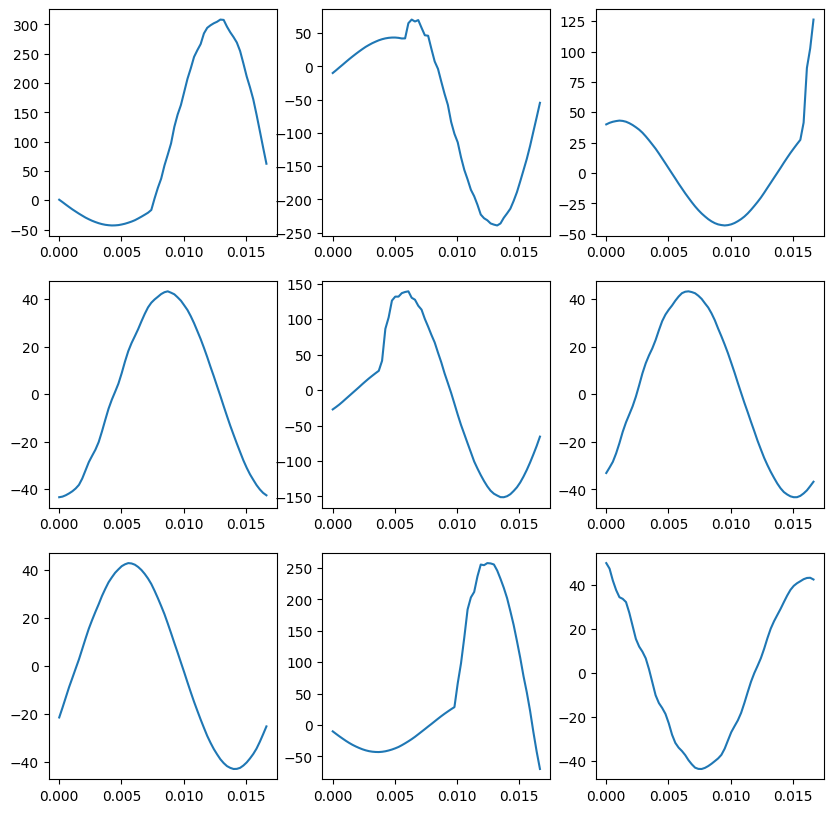

In [17]:
dataiter = iter(dev_dataloader)
signal, labels = next(dataiter)
fs = 3840
t = np.linspace(0, N / fs, N)
print(torch.reshape(labels[1:10], (1, -1)))
print(signal.shape)
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t, signal[i, :, 0])
x = model(signal[1:10].to(device))
print(torch.reshape(x, (1, -1)))
print(torch.reshape(torch.round(x), (1, -1)))


In [47]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fs = 3840
dataiter = iter(dev_dataloader)
signal, labels = next(dataiter)
t = np.linspace(0, N / fs, N)
print(torch.reshape(labels[1:10], (1, -1)))
print(signal.shape)


# figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
fig = make_subplots(rows=rows, cols=cols)

for i in range(0, cols * rows):

    col = i % cols
    row = i // cols
    fig.add_trace(go.Scatter(name=i, x=t, y=signal[i, :, 0]), row=row + 1, col=col + 1)

fig.update_layout(
    height=700,
    width=900,
    title_text="Figuras",
    margin={"b": 20, "t": 40, "l": 20, "r": 30},
)
fig.show()

x = model(signal[1:10].to(device))
print(torch.reshape(x, (1, -1)))
print(torch.reshape(torch.round(x), (1, -1)))


tensor([[1., 0., 1., 0., 0., 1., 0., 0., 0.]])
torch.Size([16, 64, 1])


tensor([[0.4644, 0.5052, 0.4783, 0.5110, 0.5057, 0.4782, 0.5070, 0.5100, 0.4620]],
       grad_fn=<ReshapeAliasBackward0>)
tensor([[0., 1., 0., 1., 1., 0., 1., 1., 0.]], grad_fn=<ReshapeAliasBackward0>)
